In [1]:
import numpy as np
import pandas as pd
from DataLoad import data_load
import torch
from torch import nn, optim, distributions
from torch.nn import functional as F
from torchvision import transforms
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt
from pylab import rcParams
import os
[weekday,weekend]=data_load()
# --- configuration --- #
BATCH_SIZE = 128
LOG_INTERVAL = 50
EPOCHS = 20
INPUT_DIM = 2
OUTPUT_DIM = 2
HIDDEN_DIM = 256
SAVE_PLT_INTERVAL = 5
N_COUPLE_LAYERS = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

rcParams['figure.figsize'] = 8, 8
plt.ion()
train_weekday, test_weekday=train_test_split(weekday,test_size=0.2,shuffle=True)
train_weekend, test_weekend=train_test_split(weekend,test_size=0.2,shuffle=True)
train_weekday=train_weekday.astype(np.float32)
test_weekday=test_weekday.astype(np.float32)
train_weekend=train_weekend.astype(np.float32)
test_weekend=test_weekend.astype(np.float32)
#train_weekday, test_weekday=torch.from_numpy(train_weekday), torch.from_numpy(test_weekday)
#train_weekend, test_weekend=torch.from_numpy(train_weekend), torch.from_numpy(test_weekend)


C:\Users\ibeis\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (3,4,5,6,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [2]:
kwargs = {'num_workers': 1, 'pin_memory': True} if device == 'cuda' else {}
train_loader = torch.utils.data.DataLoader(train_weekday, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_weekday, batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [5]:
print(min(weekday[:,1]),max(weekday[:,1]))

-4.844594275646028 11.06327138949391


In [6]:
# --- defines the model and the optimizer ---- #
class CouplingLayer(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask):
        super().__init__()
        self.s_fc1 = nn.Linear(input_dim, hid_dim)
        self.s_fc2 = nn.Linear(hid_dim, hid_dim)
        self.s_fc3 = nn.Linear(hid_dim, output_dim)
        self.t_fc1 = nn.Linear(input_dim, hid_dim)
        self.t_fc2 = nn.Linear(hid_dim, hid_dim)
        self.t_fc3 = nn.Linear(hid_dim, output_dim)
        self.mask = mask

    def forward(self, x):
        x_m = x * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(x_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(x_m)))))
        y = x_m + (1-self.mask)*(x*torch.exp(s_out)+t_out)
        log_det_jacobian = s_out.sum(dim=1)
        return y, log_det_jacobian

    def backward(self, y):
        y_m = y * self.mask
        s_out = torch.tanh(self.s_fc3(F.relu(self.s_fc2(F.relu(self.s_fc1(y_m))))))
        t_out = self.t_fc3(F.relu(self.t_fc2(F.relu(self.t_fc1(y_m)))))
        x = y_m + (1-self.mask)*(y-t_out)*torch.exp(-s_out)
        return x


class RealNVP(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, mask, n_layers = 6):
        super().__init__()
        assert n_layers >= 2, 'num of coupling layers should be greater or equal to 2'

        self.modules = []
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        for _ in range(n_layers-2):
            mask = 1 - mask
            self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, mask))
        self.modules.append(CouplingLayer(input_dim, output_dim, hid_dim, 1 - mask))
        self.module_list = nn.ModuleList(self.modules)
        
    def forward(self, x):
        ldj_sum = 0 # sum of log determinant of jacobian
        for module in self.module_list:
            x, ldj= module(x)
            ldj_sum += ldj
        return x, ldj_sum

    def backward(self, z):
        for module in reversed(self.module_list):
            z = module.backward(z)
        return z


mask = torch.from_numpy(np.array([0, 1]).astype(np.float32))
model = RealNVP(INPUT_DIM, OUTPUT_DIM, HIDDEN_DIM, mask, N_COUPLE_LAYERS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
prior_z = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))


# --- train and test --- #
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        optimizer.zero_grad()
        z, log_det_j_sum = model(data)
        loss = -(prior_z.log_prob(z)+log_det_j_sum).mean()
        loss.backward()
        cur_loss = loss.item()
        train_loss += cur_loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100.*batch_idx / len(train_loader),
                cur_loss/len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_loader.dataset)
    ))


def test(epoch):
    model.eval()
    test_loss = 0
    x_all = np.array([[]]).reshape(0,2)
    z_all = np.array([[]]).reshape(0,2)
    with torch.no_grad():
        for batch_idx, data in enumerate(test_loader):
            z, log_det_j_sum = model(data)
            cur_loss = -(prior_z.log_prob(z)+log_det_j_sum).mean().item()
            test_loss += cur_loss
            x_all = np.concatenate((x_all,data.numpy()))
            z_all = np.concatenate((z_all,z.numpy()))
        
        subfig_plot(1, x_all, -7.5, 2.7, -5, 11.2,'Input: x ~ p(x)', 'b')
        subfig_plot(2, z_all, -3, 3, -3,3,'Output: z = f(x)', 'b')

        test_loss /= len(test_loader.dataset)
        print('====> Test set loss: {:.4f}'.format(test_loss))


# --- etc. functions --- #
def sample(epoch):
    model.eval()
    with torch.no_grad():
        z = prior_z.sample((1000,))
        x = model.backward(z)
        z = z.numpy()
        x = x.numpy()

        subfig_plot(3, z, -3, 3, -3, 3, 'Input: z ~ p(z)', 'r')
        subfig_plot(4, x, -7.5, 2.7, -5, 11.2,'Output: x = g(z) (g: inverse of f)', 'r')

        if epoch % SAVE_PLT_INTERVAL == 0:
            if not os.path.exists('results'):
                os.makedirs('results')
            plt.savefig('results/'+'result_'+str(epoch)+'.png')


def subfig_plot(location, data, x_start, x_end, y_start, y_end, title, color):
        if location == 1:
            plt.clf()
        plt.subplot(2,2,location)
        plt.scatter(data[:, 0], data[:, 1], c=color, s=1)
        plt.xlim(x_start,x_end)
        plt.ylim(y_start,y_end)
        plt.title(title)
        plt.pause(1e-2)


Train Epoch: 1 [0/65266 (0%)]	Loss: 0.028839
Train Epoch: 1 [6400/65266 (10%)]	Loss: -0.040699
Train Epoch: 1 [12800/65266 (20%)]	Loss: -0.053660
Train Epoch: 1 [19200/65266 (29%)]	Loss: -0.057833
Train Epoch: 1 [25600/65266 (39%)]	Loss: -0.057020
Train Epoch: 1 [32000/65266 (49%)]	Loss: -0.057986
Train Epoch: 1 [38400/65266 (59%)]	Loss: -0.057662
Train Epoch: 1 [44800/65266 (69%)]	Loss: -0.059129
Train Epoch: 1 [51200/65266 (78%)]	Loss: -0.057319
Train Epoch: 1 [57600/65266 (88%)]	Loss: -0.058925
Train Epoch: 1 [64000/65266 (98%)]	Loss: -0.058880
====> Epoch: 1 Average loss: -0.0526


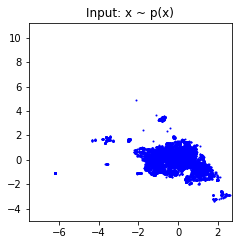

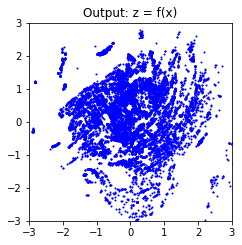

====> Test set loss: -0.0594


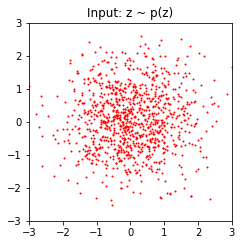

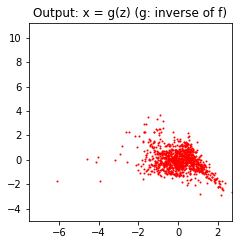

Train Epoch: 2 [0/65266 (0%)]	Loss: -0.059647
Train Epoch: 2 [6400/65266 (10%)]	Loss: -0.058216
Train Epoch: 2 [12800/65266 (20%)]	Loss: -0.058697
Train Epoch: 2 [19200/65266 (29%)]	Loss: -0.059619
Train Epoch: 2 [25600/65266 (39%)]	Loss: -0.057923
Train Epoch: 2 [32000/65266 (49%)]	Loss: -0.060431
Train Epoch: 2 [38400/65266 (59%)]	Loss: -0.059484
Train Epoch: 2 [44800/65266 (69%)]	Loss: -0.059284
Train Epoch: 2 [51200/65266 (78%)]	Loss: -0.059288
Train Epoch: 2 [57600/65266 (88%)]	Loss: -0.059616
Train Epoch: 2 [64000/65266 (98%)]	Loss: -0.060804
====> Epoch: 2 Average loss: -0.0594


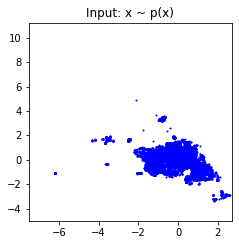

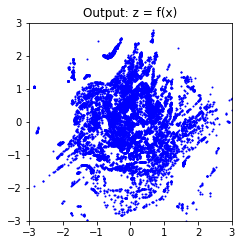

====> Test set loss: -0.0600


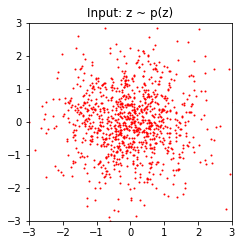

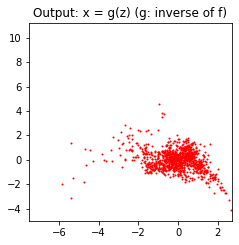

Train Epoch: 3 [0/65266 (0%)]	Loss: -0.059911
Train Epoch: 3 [6400/65266 (10%)]	Loss: -0.058986
Train Epoch: 3 [12800/65266 (20%)]	Loss: -0.059724
Train Epoch: 3 [19200/65266 (29%)]	Loss: -0.060424
Train Epoch: 3 [25600/65266 (39%)]	Loss: -0.059732
Train Epoch: 3 [32000/65266 (49%)]	Loss: -0.060367
Train Epoch: 3 [38400/65266 (59%)]	Loss: -0.060306
Train Epoch: 3 [44800/65266 (69%)]	Loss: -0.060636
Train Epoch: 3 [51200/65266 (78%)]	Loss: -0.060881
Train Epoch: 3 [57600/65266 (88%)]	Loss: -0.060914
Train Epoch: 3 [64000/65266 (98%)]	Loss: -0.058861
====> Epoch: 3 Average loss: -0.0598


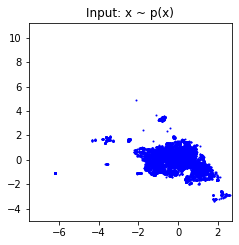

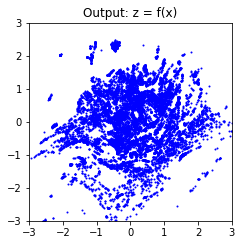

====> Test set loss: -0.0599


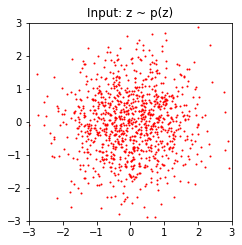

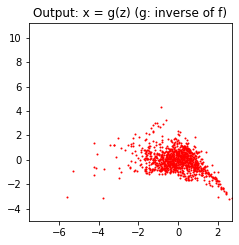

Train Epoch: 4 [0/65266 (0%)]	Loss: -0.060300
Train Epoch: 4 [6400/65266 (10%)]	Loss: -0.060179
Train Epoch: 4 [12800/65266 (20%)]	Loss: -0.060367
Train Epoch: 4 [19200/65266 (29%)]	Loss: -0.061108
Train Epoch: 4 [25600/65266 (39%)]	Loss: -0.059755
Train Epoch: 4 [32000/65266 (49%)]	Loss: -0.060667
Train Epoch: 4 [38400/65266 (59%)]	Loss: -0.059894
Train Epoch: 4 [44800/65266 (69%)]	Loss: -0.060588
Train Epoch: 4 [51200/65266 (78%)]	Loss: -0.059547
Train Epoch: 4 [57600/65266 (88%)]	Loss: -0.060786
Train Epoch: 4 [64000/65266 (98%)]	Loss: -0.059666
====> Epoch: 4 Average loss: -0.0601


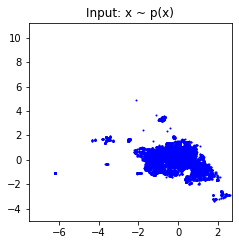

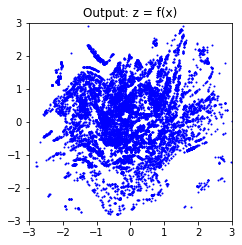

====> Test set loss: -0.0605


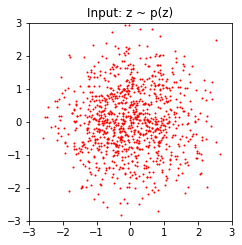

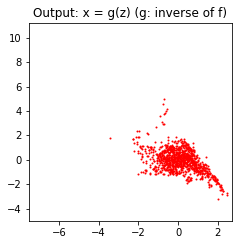

Train Epoch: 5 [0/65266 (0%)]	Loss: -0.060189
Train Epoch: 5 [6400/65266 (10%)]	Loss: -0.061228
Train Epoch: 5 [12800/65266 (20%)]	Loss: -0.059661
Train Epoch: 5 [19200/65266 (29%)]	Loss: -0.059669
Train Epoch: 5 [25600/65266 (39%)]	Loss: -0.060430
Train Epoch: 5 [32000/65266 (49%)]	Loss: -0.059672
Train Epoch: 5 [38400/65266 (59%)]	Loss: -0.060149
Train Epoch: 5 [44800/65266 (69%)]	Loss: -0.059998
Train Epoch: 5 [51200/65266 (78%)]	Loss: -0.059152
Train Epoch: 5 [57600/65266 (88%)]	Loss: -0.058486
Train Epoch: 5 [64000/65266 (98%)]	Loss: -0.060414
====> Epoch: 5 Average loss: -0.0602


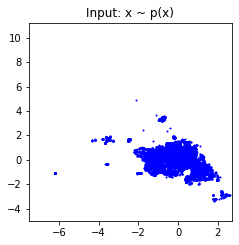

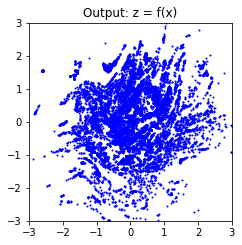

====> Test set loss: -0.0609


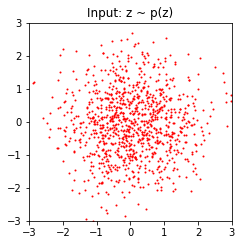

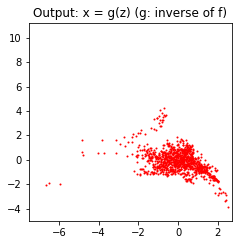

Train Epoch: 6 [0/65266 (0%)]	Loss: -0.059526
Train Epoch: 6 [6400/65266 (10%)]	Loss: -0.060731
Train Epoch: 6 [12800/65266 (20%)]	Loss: -0.060149
Train Epoch: 6 [19200/65266 (29%)]	Loss: -0.061412
Train Epoch: 6 [25600/65266 (39%)]	Loss: -0.060218
Train Epoch: 6 [32000/65266 (49%)]	Loss: -0.060793
Train Epoch: 6 [38400/65266 (59%)]	Loss: -0.060152
Train Epoch: 6 [44800/65266 (69%)]	Loss: -0.060777
Train Epoch: 6 [51200/65266 (78%)]	Loss: -0.059766
Train Epoch: 6 [57600/65266 (88%)]	Loss: -0.060057
Train Epoch: 6 [64000/65266 (98%)]	Loss: -0.060450
====> Epoch: 6 Average loss: -0.0605


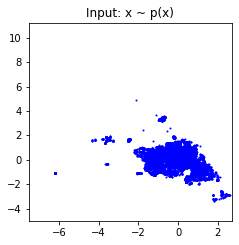

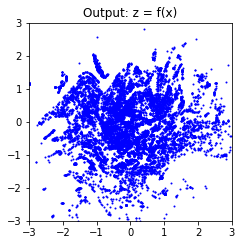

====> Test set loss: -0.0607


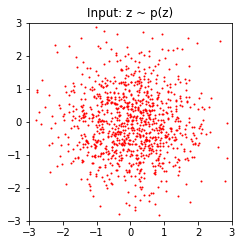

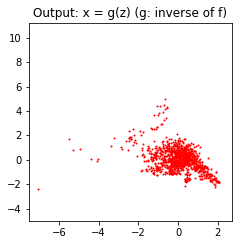

Train Epoch: 7 [0/65266 (0%)]	Loss: -0.060227
Train Epoch: 7 [6400/65266 (10%)]	Loss: -0.060904
Train Epoch: 7 [12800/65266 (20%)]	Loss: -0.061880
Train Epoch: 7 [19200/65266 (29%)]	Loss: -0.060591
Train Epoch: 7 [25600/65266 (39%)]	Loss: -0.059682
Train Epoch: 7 [32000/65266 (49%)]	Loss: -0.059280
Train Epoch: 7 [38400/65266 (59%)]	Loss: -0.059084
Train Epoch: 7 [44800/65266 (69%)]	Loss: -0.060210
Train Epoch: 7 [51200/65266 (78%)]	Loss: -0.060249
Train Epoch: 7 [57600/65266 (88%)]	Loss: -0.061613
Train Epoch: 7 [64000/65266 (98%)]	Loss: -0.060241
====> Epoch: 7 Average loss: -0.0604


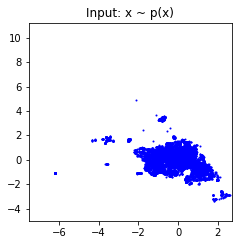

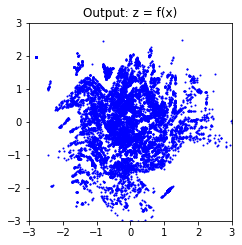

====> Test set loss: -0.0604


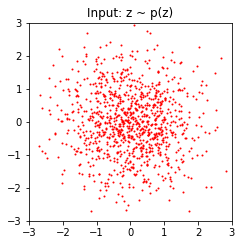

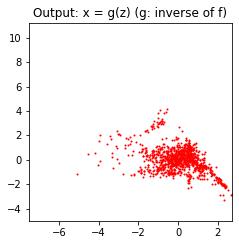

Train Epoch: 8 [0/65266 (0%)]	Loss: -0.060083
Train Epoch: 8 [6400/65266 (10%)]	Loss: -0.061701
Train Epoch: 8 [12800/65266 (20%)]	Loss: -0.060941
Train Epoch: 8 [19200/65266 (29%)]	Loss: -0.061987
Train Epoch: 8 [25600/65266 (39%)]	Loss: -0.061393
Train Epoch: 8 [32000/65266 (49%)]	Loss: -0.059696
Train Epoch: 8 [38400/65266 (59%)]	Loss: -0.059706
Train Epoch: 8 [44800/65266 (69%)]	Loss: -0.059758
Train Epoch: 8 [51200/65266 (78%)]	Loss: -0.061630
Train Epoch: 8 [57600/65266 (88%)]	Loss: -0.061499
Train Epoch: 8 [64000/65266 (98%)]	Loss: -0.060587
====> Epoch: 8 Average loss: -0.0606


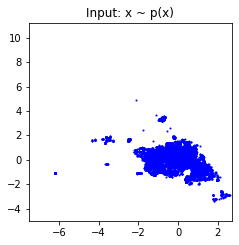

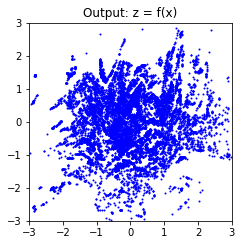

====> Test set loss: -0.0612


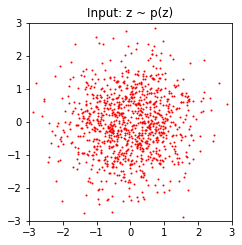

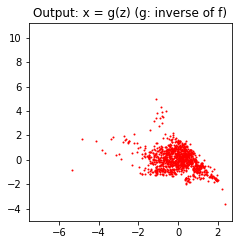

Train Epoch: 9 [0/65266 (0%)]	Loss: -0.061517
Train Epoch: 9 [6400/65266 (10%)]	Loss: -0.060583
Train Epoch: 9 [12800/65266 (20%)]	Loss: -0.060713
Train Epoch: 9 [19200/65266 (29%)]	Loss: -0.061550
Train Epoch: 9 [25600/65266 (39%)]	Loss: -0.062645
Train Epoch: 9 [32000/65266 (49%)]	Loss: -0.061208
Train Epoch: 9 [38400/65266 (59%)]	Loss: -0.061183
Train Epoch: 9 [44800/65266 (69%)]	Loss: -0.060124
Train Epoch: 9 [51200/65266 (78%)]	Loss: -0.062090
Train Epoch: 9 [57600/65266 (88%)]	Loss: -0.061677
Train Epoch: 9 [64000/65266 (98%)]	Loss: -0.057410
====> Epoch: 9 Average loss: -0.0608


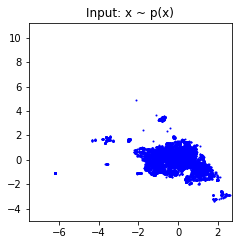

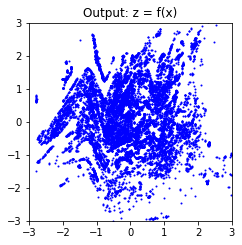

====> Test set loss: -0.0596


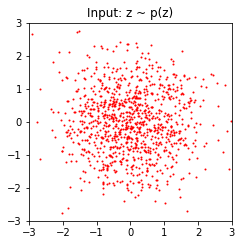

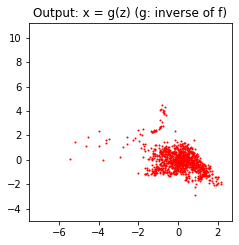

Train Epoch: 10 [0/65266 (0%)]	Loss: -0.058721
Train Epoch: 10 [6400/65266 (10%)]	Loss: -0.058658
Train Epoch: 10 [12800/65266 (20%)]	Loss: -0.061021
Train Epoch: 10 [19200/65266 (29%)]	Loss: -0.060523
Train Epoch: 10 [25600/65266 (39%)]	Loss: -0.058943
Train Epoch: 10 [32000/65266 (49%)]	Loss: -0.060700
Train Epoch: 10 [38400/65266 (59%)]	Loss: -0.060455
Train Epoch: 10 [44800/65266 (69%)]	Loss: -0.061506
Train Epoch: 10 [51200/65266 (78%)]	Loss: -0.059968
Train Epoch: 10 [57600/65266 (88%)]	Loss: -0.057436
Train Epoch: 10 [64000/65266 (98%)]	Loss: -0.061053
====> Epoch: 10 Average loss: -0.0603


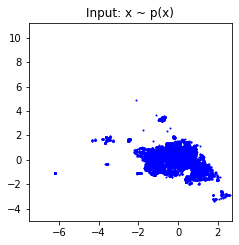

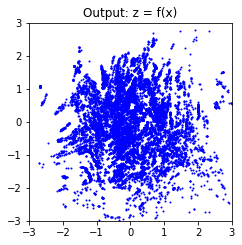

====> Test set loss: -0.0611


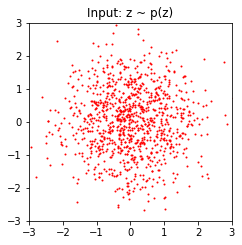

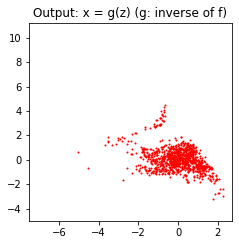

Train Epoch: 11 [0/65266 (0%)]	Loss: -0.061996
Train Epoch: 11 [6400/65266 (10%)]	Loss: -0.059465
Train Epoch: 11 [12800/65266 (20%)]	Loss: -0.060347
Train Epoch: 11 [19200/65266 (29%)]	Loss: -0.060964
Train Epoch: 11 [25600/65266 (39%)]	Loss: -0.060881
Train Epoch: 11 [32000/65266 (49%)]	Loss: -0.060404
Train Epoch: 11 [38400/65266 (59%)]	Loss: -0.061395
Train Epoch: 11 [44800/65266 (69%)]	Loss: -0.058171
Train Epoch: 11 [51200/65266 (78%)]	Loss: -0.060493
Train Epoch: 11 [57600/65266 (88%)]	Loss: -0.059118
Train Epoch: 11 [64000/65266 (98%)]	Loss: -0.060537
====> Epoch: 11 Average loss: -0.0605


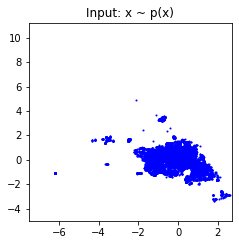

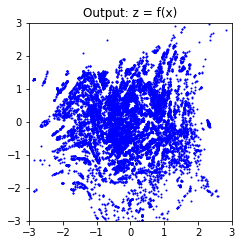

====> Test set loss: -0.0610


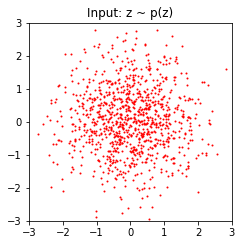

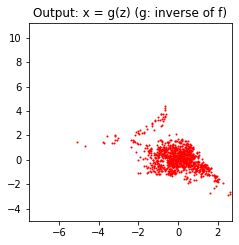

Train Epoch: 12 [0/65266 (0%)]	Loss: -0.060428
Train Epoch: 12 [6400/65266 (10%)]	Loss: -0.060444
Train Epoch: 12 [12800/65266 (20%)]	Loss: -0.059690
Train Epoch: 12 [19200/65266 (29%)]	Loss: -0.059815
Train Epoch: 12 [25600/65266 (39%)]	Loss: -0.060881
Train Epoch: 12 [32000/65266 (49%)]	Loss: -0.061276
Train Epoch: 12 [38400/65266 (59%)]	Loss: -0.061311
Train Epoch: 12 [44800/65266 (69%)]	Loss: -0.060255
Train Epoch: 12 [51200/65266 (78%)]	Loss: -0.060872
Train Epoch: 12 [57600/65266 (88%)]	Loss: -0.058749
Train Epoch: 12 [64000/65266 (98%)]	Loss: -0.061764
====> Epoch: 12 Average loss: -0.0605


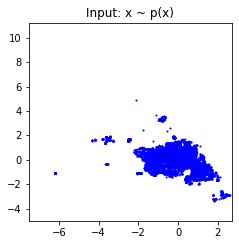

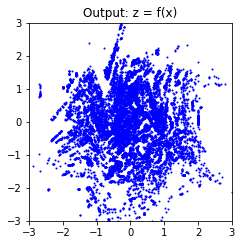

====> Test set loss: -0.0610


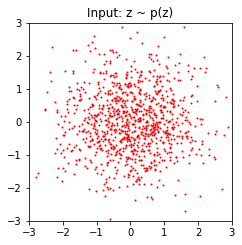

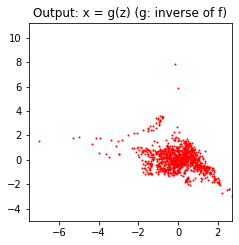

Train Epoch: 13 [0/65266 (0%)]	Loss: -0.061124
Train Epoch: 13 [6400/65266 (10%)]	Loss: -0.060449
Train Epoch: 13 [12800/65266 (20%)]	Loss: -0.060919
Train Epoch: 13 [19200/65266 (29%)]	Loss: -0.060461
Train Epoch: 13 [25600/65266 (39%)]	Loss: -0.060331
Train Epoch: 13 [32000/65266 (49%)]	Loss: -0.061269
Train Epoch: 13 [38400/65266 (59%)]	Loss: -0.060231
Train Epoch: 13 [44800/65266 (69%)]	Loss: -0.061920
Train Epoch: 13 [51200/65266 (78%)]	Loss: -0.062250
Train Epoch: 13 [57600/65266 (88%)]	Loss: -0.061279
Train Epoch: 13 [64000/65266 (98%)]	Loss: -0.061152
====> Epoch: 13 Average loss: -0.0609


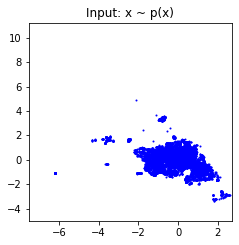

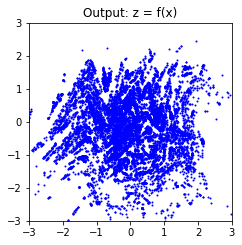

====> Test set loss: -0.0611


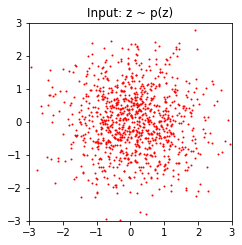

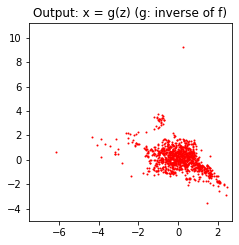

Train Epoch: 14 [0/65266 (0%)]	Loss: -0.062319
Train Epoch: 14 [6400/65266 (10%)]	Loss: -0.059666
Train Epoch: 14 [12800/65266 (20%)]	Loss: -0.061843
Train Epoch: 14 [19200/65266 (29%)]	Loss: -0.060645
Train Epoch: 14 [25600/65266 (39%)]	Loss: -0.060539
Train Epoch: 14 [32000/65266 (49%)]	Loss: -0.060365
Train Epoch: 14 [38400/65266 (59%)]	Loss: -0.061795
Train Epoch: 14 [44800/65266 (69%)]	Loss: -0.058624
Train Epoch: 14 [51200/65266 (78%)]	Loss: -0.060660
Train Epoch: 14 [57600/65266 (88%)]	Loss: -0.060890
Train Epoch: 14 [64000/65266 (98%)]	Loss: -0.062038
====> Epoch: 14 Average loss: -0.0610


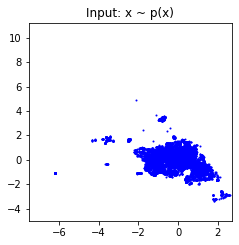

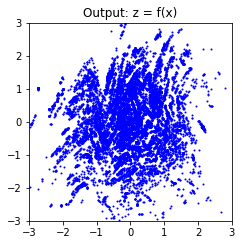

====> Test set loss: -0.0613


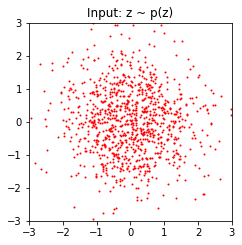

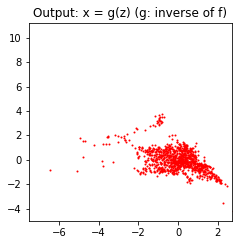

Train Epoch: 15 [0/65266 (0%)]	Loss: -0.060628
Train Epoch: 15 [6400/65266 (10%)]	Loss: -0.061887
Train Epoch: 15 [12800/65266 (20%)]	Loss: -0.061242
Train Epoch: 15 [19200/65266 (29%)]	Loss: -0.061429
Train Epoch: 15 [25600/65266 (39%)]	Loss: -0.062061
Train Epoch: 15 [32000/65266 (49%)]	Loss: -0.058885
Train Epoch: 15 [38400/65266 (59%)]	Loss: -0.061184
Train Epoch: 15 [44800/65266 (69%)]	Loss: -0.062681
Train Epoch: 15 [51200/65266 (78%)]	Loss: -0.062669
Train Epoch: 15 [57600/65266 (88%)]	Loss: -0.061891
Train Epoch: 15 [64000/65266 (98%)]	Loss: -0.061288
====> Epoch: 15 Average loss: -0.0611


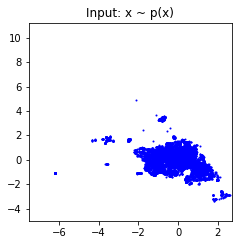

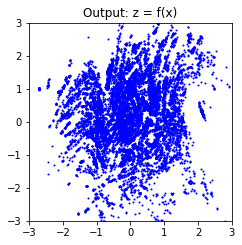

====> Test set loss: -0.0611


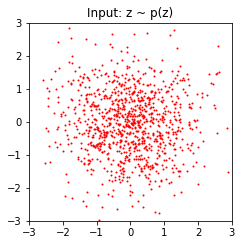

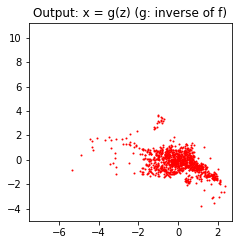

Train Epoch: 16 [0/65266 (0%)]	Loss: -0.060011
Train Epoch: 16 [6400/65266 (10%)]	Loss: -0.061284
Train Epoch: 16 [12800/65266 (20%)]	Loss: -0.061777
Train Epoch: 16 [19200/65266 (29%)]	Loss: -0.062380
Train Epoch: 16 [25600/65266 (39%)]	Loss: -0.061167
Train Epoch: 16 [32000/65266 (49%)]	Loss: -0.060572
Train Epoch: 16 [38400/65266 (59%)]	Loss: -0.062337
Train Epoch: 16 [44800/65266 (69%)]	Loss: -0.061594
Train Epoch: 16 [51200/65266 (78%)]	Loss: -0.061225
Train Epoch: 16 [57600/65266 (88%)]	Loss: -0.062247
Train Epoch: 16 [64000/65266 (98%)]	Loss: -0.061737
====> Epoch: 16 Average loss: -0.0612


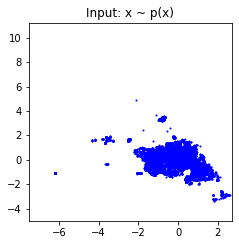

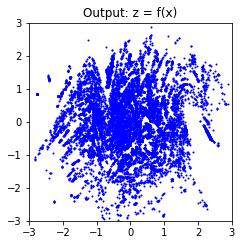

====> Test set loss: -0.0614


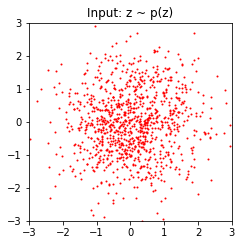

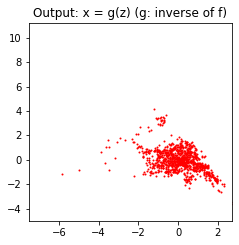

Train Epoch: 17 [0/65266 (0%)]	Loss: -0.062168
Train Epoch: 17 [6400/65266 (10%)]	Loss: -0.061304
Train Epoch: 17 [12800/65266 (20%)]	Loss: -0.061943
Train Epoch: 17 [19200/65266 (29%)]	Loss: -0.061313
Train Epoch: 17 [25600/65266 (39%)]	Loss: -0.060133
Train Epoch: 17 [32000/65266 (49%)]	Loss: -0.060923
Train Epoch: 17 [38400/65266 (59%)]	Loss: -0.061613
Train Epoch: 17 [44800/65266 (69%)]	Loss: -0.062383
Train Epoch: 17 [51200/65266 (78%)]	Loss: -0.062132
Train Epoch: 17 [57600/65266 (88%)]	Loss: -0.062725
Train Epoch: 17 [64000/65266 (98%)]	Loss: -0.061693
====> Epoch: 17 Average loss: -0.0613


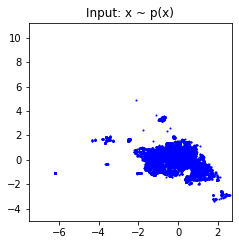

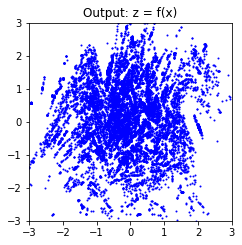

====> Test set loss: -0.0616


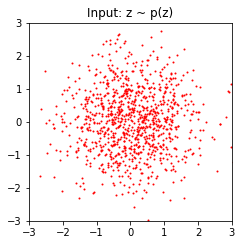

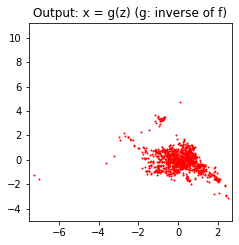

Train Epoch: 18 [0/65266 (0%)]	Loss: -0.061478
Train Epoch: 18 [6400/65266 (10%)]	Loss: -0.061173
Train Epoch: 18 [12800/65266 (20%)]	Loss: -0.061371
Train Epoch: 18 [19200/65266 (29%)]	Loss: -0.061490
Train Epoch: 18 [25600/65266 (39%)]	Loss: -0.062151
Train Epoch: 18 [32000/65266 (49%)]	Loss: -0.059556
Train Epoch: 18 [38400/65266 (59%)]	Loss: -0.061207
Train Epoch: 18 [44800/65266 (69%)]	Loss: -0.061844
Train Epoch: 18 [51200/65266 (78%)]	Loss: -0.061189
Train Epoch: 18 [57600/65266 (88%)]	Loss: -0.061082
Train Epoch: 18 [64000/65266 (98%)]	Loss: -0.062159
====> Epoch: 18 Average loss: -0.0613


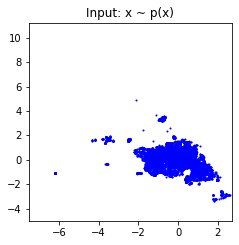

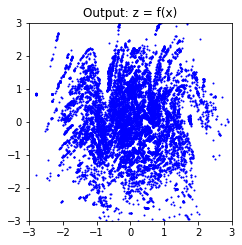

====> Test set loss: -0.0617


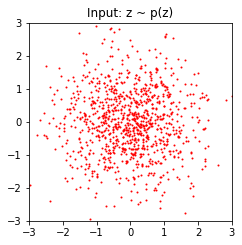

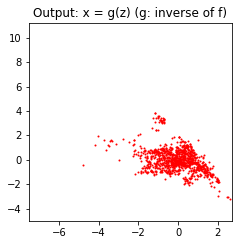

Train Epoch: 19 [0/65266 (0%)]	Loss: -0.060705
Train Epoch: 19 [6400/65266 (10%)]	Loss: -0.061499
Train Epoch: 19 [12800/65266 (20%)]	Loss: -0.061571
Train Epoch: 19 [19200/65266 (29%)]	Loss: -0.063030
Train Epoch: 19 [25600/65266 (39%)]	Loss: -0.061811
Train Epoch: 19 [32000/65266 (49%)]	Loss: -0.062211
Train Epoch: 19 [38400/65266 (59%)]	Loss: -0.061348
Train Epoch: 19 [44800/65266 (69%)]	Loss: -0.061131
Train Epoch: 19 [51200/65266 (78%)]	Loss: -0.061904
Train Epoch: 19 [57600/65266 (88%)]	Loss: -0.062421
Train Epoch: 19 [64000/65266 (98%)]	Loss: -0.061221
====> Epoch: 19 Average loss: -0.0613


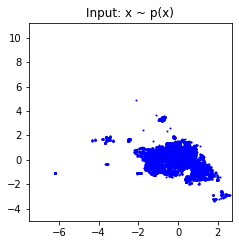

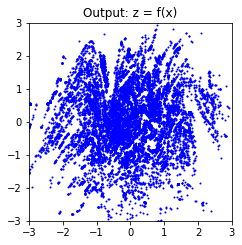

====> Test set loss: -0.0618


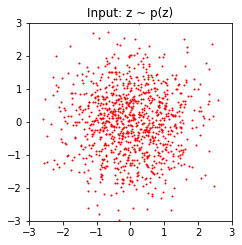

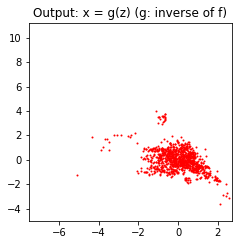

Train Epoch: 20 [0/65266 (0%)]	Loss: -0.060480
Train Epoch: 20 [6400/65266 (10%)]	Loss: -0.062224
Train Epoch: 20 [12800/65266 (20%)]	Loss: -0.060717
Train Epoch: 20 [19200/65266 (29%)]	Loss: -0.061872
Train Epoch: 20 [25600/65266 (39%)]	Loss: -0.060961
Train Epoch: 20 [32000/65266 (49%)]	Loss: -0.060135
Train Epoch: 20 [38400/65266 (59%)]	Loss: -0.061299
Train Epoch: 20 [44800/65266 (69%)]	Loss: -0.061422
Train Epoch: 20 [51200/65266 (78%)]	Loss: -0.062203
Train Epoch: 20 [57600/65266 (88%)]	Loss: -0.061507
Train Epoch: 20 [64000/65266 (98%)]	Loss: -0.061138
====> Epoch: 20 Average loss: -0.0615


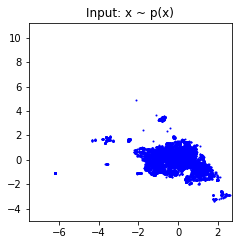

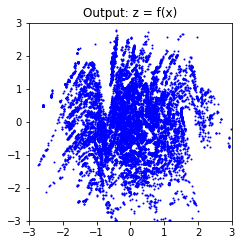

====> Test set loss: -0.0615


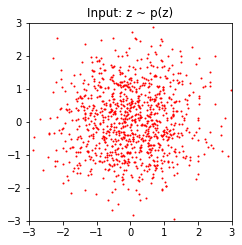

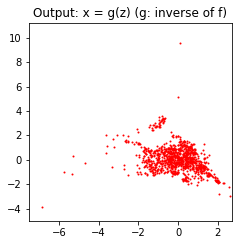

<Figure size 576x576 with 0 Axes>

In [7]:
for epoch in range(1,EPOCHS+1):
    train(epoch)
    test(epoch)
    sample(epoch)